## Interferometric Transformer (IT) Model for Natural Language Processing (NLP)

This notebook is based on __Andrej Karpathy__'s [YouTube lecture video](https://www.youtube.com/watch?v=kCc8FmEb1nY&t=120s) and the associated [Notebook](https://colab.research.google.com/drive/1JMLa53HDuA-i7ZBmqV7ZnA3c_fvtXnx-?usp=sharing#scrollTo=wJpXpmjEYC_T). Big thanks to Andrej Karpathy!

### Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.nn import functional as F


import tiktoken                                             # !pip install tiktoken (tiktoken is a fast BPE tokeniser for use with OpenAI's models.)
from transformers import get_cosine_schedule_with_warmup

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

### Load the [tiny shakespeare](https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt) dataset for training

This code block reads the tiny Shakespeare dataset stored locally, builds a character-level vocabulary, and encodes the text into a tensor of integer token IDs. It then splits the encoded data into 90% training and 10% validation sets.

In [2]:
%%time

with open('tiny_shakespeare.txt', 'r', encoding='utf-8') as f:
    text = f.read()

print(f'number of characters: {len(text)}\n')


#=======================================================================================================
# here are all the unique characters that occur in this text

chars = sorted(list(set(text)))
vocab_size = len(chars)
print(f'vocab_size = {vocab_size}')

stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s]               # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l])      # decoder: take a list of integers, output a string

data = torch.tensor(encode(text), dtype=torch.long)   # encode the entire text dataset and store it into a torch.Tensor

#=======================================================================================================

# LLModel = 'gpt2'
# enc = tiktoken.encoding_for_model(LLModel) # can use other model at the place of 'gpt2' form the OpenAI Cookbook.
# vocab_size = enc.n_vocab
# print(f'number of tockens in the LLModel {LLModel} = {vocab_size}')
# data = torch.tensor(enc.encode(text), dtype=torch.long)

#=======================================================================================================

data_size = len(data)
print(f'dataset size = {data_size}\n')


# Let's now split up the data into train and validation sets
n = int(0.9 * data_size) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]


number of characters: 1115394

vocab_size = 65
dataset size = 1115394

CPU times: user 63.5 ms, sys: 5.99 ms, total: 69.5 ms
Wall time: 69.1 ms


### Interferometric Transformer (IT) Model

This code implements a custom IT Model that is a combination of the famous [Transformer Architecture](https://arxiv.org/abs/1706.03762) and our [Interferometric Neural Networks (INN)](https://arxiv.org/abs/2310.16742).
In an INN, an interferometer is made of beamsplitters (or fiber couplers) and a phase shifter. A beamsplitter is represented by a discrete Fourier transformation (FT), and the phase shifters hold all the learnable parameters (phases).




$\bullet$ __get_batch__: Picks random slices of the dataset to form input (x) and target (y) sequences of length `block_size`, and moves them to the right device for training. <br>
$\bullet$ __interferometric_embedding__: Learns a “phase” vector for each token index. Applies those phases to an equal‑superposition state ${|+\rangle}$ with the phase shifter, runs an FFT, and measures in the computational basis to produce a probability vector. <br>
$\bullet$ __parallel_interferometers__: Takes input probability vectors, standardizes and normalizes them into unit‑length “state” vectors. Applies many interferometers (phase‑shifters + FFTs) in parallel. Measures each output to get new probability vectors. <br>
$\bullet$ __interferometric_self_attention_head__: Uses three `parallel_interferometers` to produce queries, keys, and values from the token embeddings.
Computes attention scores (weights) by multiplying queries with keys, and applies a causal mask so tokens only attend to past positions.
Aggregates values via those weights to produce one attention head’s output. <br>
$\bullet$ __interferometric_multi_head_attention__: Runs several self‑attention heads in parallel and concatenates their outputs. Applies one more interferometric projection to mix head outputs. <br>
$\bullet$ __interferometric_feedforward__: A two‑stage interferometric network that upsamples then downsamples each token’s representation, adding nonlinearity and depth. <br>
$\bullet$ __interferometric_block__: 
One Transformer block: <br>
Self‑attention + skip connection <br>
Feed‑forward + skip connection <br>
$\bullet$ __interferometric_transformer (IT)__:<br>
Embedding: maps token indices to probability vectors. <br>
Blocks: stacks multiple interferometric blocks. <br>
Output projection: maps final features back to vocabulary‑sized probabilities. <br>
Loss: computes negative log‑likelihood if targets are given. <br>
Generation: autoregressively samples new tokens by repeatedly feeding the model’s last output back as input. <br>



Altogether, this defines an "Interferometric Transformer" that replaces classical linear layers with learned interferometric networks—comprising phase shifters and beamsplitters (Fourier transformations). These can be implemented on a photonic chip or a quantum computer. 
This notebook provides a classical simulation of interferometers (phase shifters and FFT) using PyTorch. Notably, the Fourier transform on a quantum computer is exponentially faster than the classical FFT.


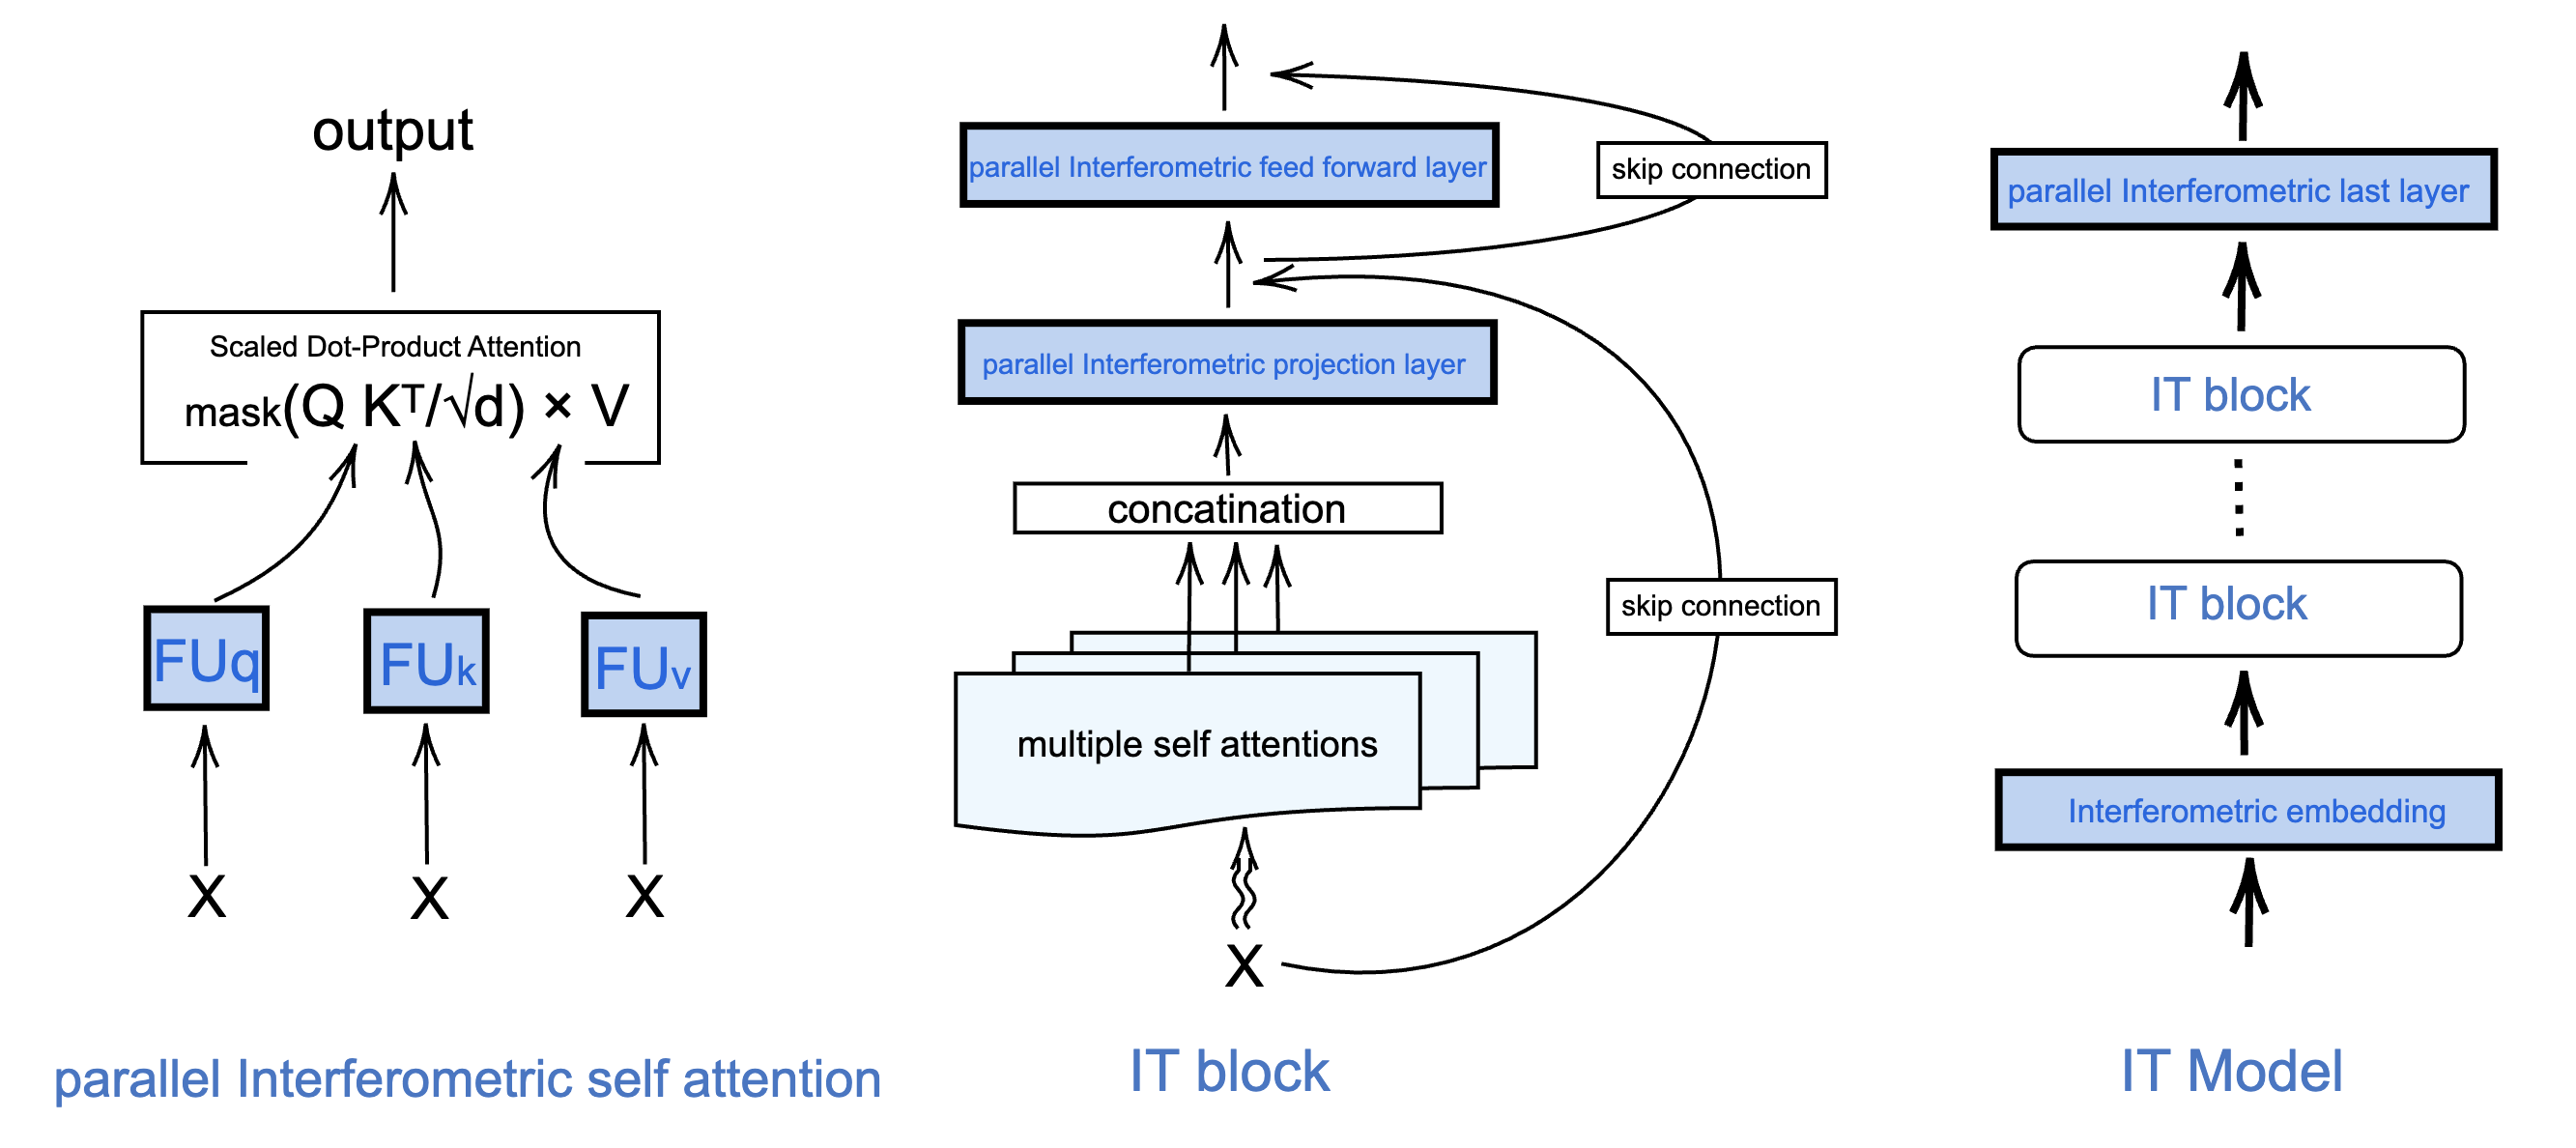


In [3]:
#torch.manual_seed(1)                                          # setting a specific seed for reproducibility of results


def get_batch(dataset, batch_size, block_size):
    # generate a small batch of data of inputs x and targets y
    ix = torch.randint(len(dataset) - block_size, (batch_size,))
    x = torch.stack([dataset[i:i+block_size] for i in ix])
    y = torch.stack([dataset[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y




class interferometric_embedding(nn.Module):
    ''' Maps token indices i to learnable probability vectors via phase shifters + FFT.'''

    def __init__(self, num_embd, embd_dim):
        super().__init__()

        self.embd_dim = embd_dim

        phases = torch.randn((num_embd, embd_dim), dtype=torch.float)    
        nn.init.xavier_uniform_(phases)
        self.phases = nn.Parameter(phases)

    def forward(self, x):                                     # Input tensor x of integers of shape (B, T) where B is batch size and T is block size.
        
        phi = self.phases[x]                                  # Select phase vector phi_i corresponding to each token index i in 'x'. x.shape = (B, T, embd_dim)
        x = torch.exp(1j * phi) / np.sqrt(self.embd_dim)      # Perform phase shifters on the equal superposition |+> ket: U(Phi_i)|+>
        x = torch.fft.fft(x, norm='ortho')                    # Perform parallel 1D Fast Fourier Transforms (beamsplitters): |Phi_i> = FU(Phi_i)|+> 
                                                              # measurement in computation basis {|l>} 
        x = x*(x.conj())                                      # For each i, probability-vector made of |<l|Phi_i>|^2 where l = 0,1,..., embd_dim -1 
        return x                                              # although x shows complex here, its imaginary part is (almost) zero                                  




class parallel_interferometers(nn.Module):
    ''' Applies multiple interferometers in parallel to vectors of probabilities.'''
    
    def __init__(self, dim_in, dim_out):
        super().__init__()
 
        self.dim_in = dim_in

        phases = torch.randn((dim_in, dim_out), dtype=torch.float)     
        nn.init.xavier_uniform_(phases)
        self.phases = nn.Parameter(phases)

    def forward(self, x):                                  # (B, T, dim_in)            here dim_in = embd_dim
        # if input x is made of probabilities, it has only positive numbers 
        # then, after z-score normalization or LayerNorm (zero mean and unit variance), output x has both positive and negative numbers
        x = (x - torch.mean(x, dim=-1, keepdim=True))/(torch.std(x, dim=-1, keepdim=True) + 1e-10)  
        x = F.normalize(x, p=2, dim=-1)                               # turning vectors x into quantum state-vectors |x>
        
        # Perform dim_out parallel phase shifters, beamsplitters (Fast Fourier Transforms), and the measurement in computational basis {|l>}
        # (B, T, dim_in) @ (dim_in, dim_out) --> (B, T, dim_out)
        
        x = (x @ torch.exp(1j * self.phases)) / np.sqrt(self.dim_in)  # probability amplitudes = <0|FU(Phi_k)|x>    for k = 0,1,..., dim_out -1       
        
        x = x*(x.conj())                                              # probability p_k = |<0|FU(Phi_k)|x>|^2. Note: sum_k p_k is not necessarily 1.    
        return x                                                      # the probabilities come from quantum interferences of components of x with phases 


#===========================================================================================================================================
#===========================================================================================================================================


class interferometric_self_attention_head(nn.Module):
    def __init__(self, dim_in, dim_out, block_size):
        super().__init__()
        
        self.key = parallel_interferometers(dim_in, dim_out)                    # here (dim_in, dim_out) = (embd_dim, head_size)
        self.query = parallel_interferometers(dim_in, dim_out)
        self.value = parallel_interferometers(dim_in, dim_out)

        # Register `tril (lower triangular matrix for masking)` as a buffer so that it is not updated during training
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

    def forward(self, x):                        # x.shape = (B, T, embd_dim)
        
        B,T,C = x.shape
        
        k = self.key(x)                         # k.shape = (B, T, head_size)  passing kets |x> -- through parallel_interferometers --> |<0|k>|^2
        q = self.query(x)                       # q.shape = (B, T, head_size)  passing kets |x> -- through another parallel_interferometers --> |<0|q>|^2
        v = self.value(x)                       # v.shape = (B, T, head_size)  passing kets |x> -- through yet another parallel_interferometers --> |<0|v>|^2
        
        # compute attention scores ('affinities') through the multiplication of matrices (in the classical computer) q and k made of probabilities
        # weights are not normalized 
        weights = q @ k.transpose(-2,-1) * C**0.5                  # (B, T, head_size) @ (B, head_size, T) -> (B, T, T)
        weights = weights.masked_fill(self.tril[:T,:T]==0, 0)      # (B, T, T) lower triangular matrix for masking

        
        # perform the weighted aggregation of the values (in the classical computer): (B, T, T) @ (B, T, head_size) -> (B, T, head_size)
        out = weights @ v                                     
        
        return out




class interferometric_multi_head_attention(nn.Module):
    ''' multiple heads of interferometric self-attention in parallel '''

    def __init__(self, embd_dim, num_heads, block_size):
        super().__init__()
        head_size = embd_dim // num_heads
        
        self.heads = nn.ModuleList([interferometric_self_attention_head(embd_dim, head_size, block_size) for _ in range(num_heads)])
        self.proj = parallel_interferometers(embd_dim, embd_dim)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)  # Aggregate outputs from all heads (communication)
        out = self.proj(out)                                 # Apply a final unitary transformation (computation)
        return out


class interferometric_feedfoward(nn.Module):
    """ A simple interferometric feedforward layer """

    def __init__(self, embd_dim):
        super().__init__()
        self.net = nn.Sequential(
            parallel_interferometers(embd_dim, 4 * embd_dim),
            parallel_interferometers(4 * embd_dim, embd_dim)
        )

    def forward(self, x):
        return self.net(x)


class interferometric_block(nn.Module):
    ''' Interferometric Transformer (IT) Block: communication followed by computation '''

    def __init__(self, embd_dim, num_heads, block_size):
        super().__init__()
        self.attn = interferometric_multi_head_attention(embd_dim, num_heads, block_size) 
        self.ffwd = interferometric_feedfoward(embd_dim) 
    def forward(self, x):
        x = x + self.attn(x)          # Skip connection after attention
        x = x + self.ffwd(x)          # Skip connection after feedforward
        return x


#===========================================================================================================================================
#===========================================================================================================================================


class IT(nn.Module):
    def __init__(self, vocab_size, block_size, embd_dim, num_heads, num_blks):
        super(IT, self).__init__()
        
        self.token_embedding_table = interferometric_embedding(vocab_size, embd_dim)     
        self.blocks = nn.Sequential(*[interferometric_block(embd_dim, num_heads, block_size) for k in range(num_blks)])
        self.last_layer = parallel_interferometers(embd_dim, vocab_size) 
        
    
    def forward(self, x, targets=None):
        B, T = x.shape
        
        x = self.token_embedding_table(x)              # x.shape: (B, T, vocab_size)        
        x = self.blocks(x)                   
        x = self.last_layer(x)                                   
        
        # p_ij = probability of the next token being j, given the current token i                            
        probs = torch.real(x)                          # Here sum_j p_ij is not 1 
        probs = F.normalize(probs, p=1, dim=-1)        # Now sum_j p_ij = 1 

        # Compute loss if targets are provided
        loss = None
        if targets is not None:
            B, T, C = probs.shape
            probs = probs.view(B * T, C)             # Flatten to (B*T, C) for loss
            targets = targets.view(B * T)            # Flatten to (B*T)

            log_probs = torch.log(probs + 1e-30)
            loss = F.nll_loss(log_probs, targets)    # negative log-likelihood loss without Softmax
            
        return probs, loss

    
    def generate(self, x, block_size, max_new_tokens):
        ''' 
        Generate new tokens based on the input x that is (B, T) array of indices in the current context
        Output: the original sequence with new tokens appended of shape (B, T + max_new_tokens)
        '''
        for _ in range(max_new_tokens):
            # crop x to the last block_size tokens
            x_cond = x[:, -block_size:]
            
            # Get probs (output) from the model for the current sequence (no loss calculation needed)
            probs, _ = self.forward(x_cond)  # (B, T, C)

            # Focus on the last time step's probs (B, C), here probs = probabilities over the vocabulary so there is no need for softmax
            probs = probs[:, -1, :]
            #probs = F.normalize(probs, p=1, dim=-1)        # Now sum_j p_ij = 1 

            # Sample the next token from the probability distribution
            x_next = torch.multinomial(probs, num_samples=1)  # (B, 1)

            # Append the predicted token to the sequence
            x = torch.cat((x, x_next), dim=1)  # (B, T+1)

        return x



### Generate text from the __untrained__ IT Model

In [4]:

xb, yb = get_batch(train_data, batch_size=8, block_size=8)
model = IT(vocab_size, block_size=8, embd_dim=16, num_heads=2, num_blks=1).to(device)                          
probs, loss = model(xb, yb)    
print(f'Initial loss = {loss}          -ln(1/vocab_size) = {-np.log(1/vocab_size)}\n')


x_input = torch.tensor([[0]], dtype=torch.long).to(device)           # input context of shape (B, T)
print('Text generated from untrained model:')
print(decode(model.generate(x = x_input, block_size=8, max_new_tokens=500)[0].tolist()))


Initial loss = 5.2987470626831055          -ln(1/vocab_size) = 4.174387269895637

Text generated from untrained model:

bfJHox,qAqdj&dfdybd,-3EHidoyN,h!yq.mFd3ydyjyhouQ!d;yx.o,BhudFxdE!JxdooGhbLTQOid$vJnhJnQ-E-sxvpbqJxfhTxvOvdyvmJmFddhd!H,fdEy-NNu3sqy!FBodfygs;kH!g!jEh$G?oOvT,h$FXb,b?..O.oNfv,d JBx3OyojhNdNs,O!sOiJmy..oHshxNAQddObsEdddv,ydEOdd-H,EdxN!EjFyd$zGoEPxyN,MEAGjE,yJyZuxf.oH,doNyO,ufvoE$,nJdqdOxQd.JONxdmE33,Fym Jy,,Fm,,O$dqixf.h!ydxqzb.!JddohE!HHhd,E,bi?gWJoyHsJjvv.Nnf$hdZE&dNqd-KbAx!fdxxbif$fgh,hb,dyhh,Z$oDxPvAofu3dbzudFH,,ioAj,qiHsHxxdJHiyDHB$-JhiovuJoBdyUHxHx!.bxmfdoJQFExqovzusdsnJdddvnx,d.d,,yhqJh?dJ-


### Train IT Model

In [5]:
# =======================================================================================================
# To estimate losses on the training and validation datasets in the training process

@torch.no_grad()
def estimate_loss(eval_iters):
    train_val_losses = []
    model.eval()
    for dataset in [train_data, val_data]:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            xb, yb = get_batch(dataset, batch_size, block_size)            # Sample a batch of training or validation dataset
            probs, loss = model(xb, yb)                                    # Forward pass to calculate loss
            losses[k] = loss.item()
        mean_loss = losses.mean()
        train_val_losses.append(mean_loss)
    model.train()
    return train_val_losses

#=======================================================================================================
# Define hyperparameters

batch_size, block_size = 16, 32
embd_dim = 64
num_heads = 4
num_blks = 5
num_iterations = 5001            

print(f'embd_dim = {embd_dim}, head_size = {embd_dim//num_heads}')

# Initialize the model
model = IT(vocab_size, block_size, embd_dim, num_heads, num_blks).to(device)
print(sum(p.numel() for p in model.parameters()), 'parameters') # print the number of parameters in the model


eval_iters = 10                                                 # number of batches on which loss is averaged 

#=======================================================================================================
# Set up PyTorch optimizer 

lr = 1e-2

b1 = 0.9
b2 = 0.99

optimizer = torch.optim.AdamW(model.parameters(), lr=lr, betas=(b1, b2))

# Scheduler with cosine annealing after warm-up
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=2000, num_training_steps=num_iterations)


embd_dim = 64, head_size = 16
254080 parameters


Iteration:    0,  Learning Rate = 0.000005,   mean train loss: 5.1200,   mean val loss: 5.0472
Iteration:  200,  Learning Rate = 0.001005,   mean train loss: 3.2321,   mean val loss: 3.3422
Iteration:  400,  Learning Rate = 0.002005,   mean train loss: 2.5775,   mean val loss: 2.6118
Iteration:  600,  Learning Rate = 0.003005,   mean train loss: 2.5220,   mean val loss: 2.5133
Iteration:  800,  Learning Rate = 0.004005,   mean train loss: 2.4749,   mean val loss: 2.5004
Iteration: 1000,  Learning Rate = 0.005005,   mean train loss: 2.3640,   mean val loss: 2.3879
Iteration: 1200,  Learning Rate = 0.006005,   mean train loss: 2.3172,   mean val loss: 2.3440
Iteration: 1400,  Learning Rate = 0.007005,   mean train loss: 2.3225,   mean val loss: 2.3540
Iteration: 1600,  Learning Rate = 0.008005,   mean train loss: 2.2525,   mean val loss: 2.2768
Iteration: 1800,  Learning Rate = 0.009005,   mean train loss: 2.2194,   mean val loss: 2.2347
Iteration: 2000,  Learning Rate = 0.010000,   mean

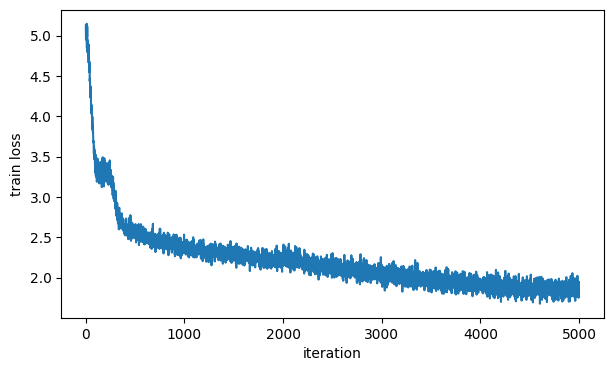

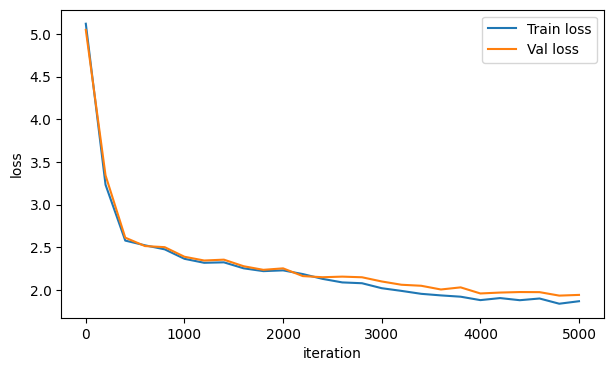

CPU times: user 23min 29s, sys: 11min 17s, total: 34min 47s
Wall time: 15min 52s


In [6]:
%%time

#-------------------------------------------------------------------------------
# List to track loss during training
iter_loss = []
LOSSES = []

# Training ...
for iter in range(num_iterations): 
    optimizer.step()
    scheduler.step()
    current_lr = scheduler.get_last_lr()[0]

    xb, yb = get_batch(train_data, batch_size, block_size)         # Sample a batch of training data
    probs, loss = model(xb, yb)                                    # Forward pass to calculate loss
    optimizer.zero_grad(set_to_none=True)                          # Reset gradients to avoid accumulation
    loss.backward()                                                # Backpropagation to compute gradients
    optimizer.step()                                               # Update model parameters

    iter_loss.append(loss.item())                                  # Append the current loss to track progress
    
    # print progress after a certain number of iterations
    if iter % 200 == 0:
        train_val_losses = estimate_loss(eval_iters=eval_iters)    # Note: this estimation is taking some time
        print(f'Iteration: {iter:4d},  Learning Rate = {current_lr:.6f},   mean train loss: {train_val_losses[0]:.4f},   mean val loss: {train_val_losses[1]:.4f}')
        LOSSES.append([iter, train_val_losses[0], train_val_losses[1]])

#-------------------------------------------------------------------------------

plt.figure(figsize=(7,4))
plt.plot(iter_loss)
plt.xlabel('iteration')
plt.ylabel('train loss')
plt.show()


LOSSES = np.array(LOSSES)
plt.figure(figsize=(7,4))
plt.plot(LOSSES[:,0], LOSSES[:,1], label='Train loss')
plt.plot(LOSSES[:,0], LOSSES[:,2], label='Val loss')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.legend()
plt.show()

### Generate text from the trained IT model

In [9]:
%%time

print(decode(model.generate(x = torch.tensor([[0]], dtype=torch.long).to(device), block_size=block_size, max_new_tokens=1000)[0].tolist()), '\n')



This is throue rebee our lecaw;
now manne'd thee pridan'd bolsengsh;
Fret nighal be tristelar not weath me, your no them's. Hare for us Randstandio.

Knlome, ueven I aponss it seact sore.

AUCCERK-me I for thang facham asth your mut! whe the now kithIs en shoous
Thus be some hand
To joorsan hon thim bether be vandhom'd stad,
I fir gold, and my-mrry, my benckiourd
But the mertious like the chall on.
That ronng dowers then's this itut badons.

SSGeds Horsh:
I, and youm cursain: band the as and by heher deard dightanes aht thy weren
Rec.
Mdlforrizesfon whourd that rest
to the kild, am make wife ming and of this so ron lake sway word.

SecoLo foarouth of that make to them:
Fare you pat soun. with our swilt inst metred,
The clild ir, hat kee frel
Autt the crigend tumparls, he mre lich emys
Barbe Ede have fors I sand ace end iglints wand nor st,
I bu amin, lie fove giught diess?

MOchan: deaorthin she him thoustt! a thave to a beltury sextiogn,
And no charive quorn an be
in togher-dispeler'